# Predict Future Sales

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/ubuntu/fastai')

from fastai.structured import *
from fastai.column_data import *

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Settings

PATH='data/predict_future_sales/'
DO_SAMPLE = False

In [4]:
data = pd.read_pickle(PATH+'processed_data.pkl')

In [5]:
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,1,2013,28.0,-1,-1,0,0
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,1,2013,28.0,-1,-1,0,0
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,1,2013,28.0,-1,-1,0,0
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,1,2013,28.0,-1,-1,0,0
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,1,2013,28.0,-1,-1,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 41 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12           f

In [7]:
dep = 'item_cnt_month'

cat_vars = ['shop_id', 'item_id', 'city_code', 'item_category_id', 'type_code', 
            'subtype_code', 'month', 'year']

contin_vars = ['date_block_num', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 
               'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 
               'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2', 
               'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
               'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
               'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
               'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
               'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
               'date_shop_type_avg_item_cnt_lag_1', 'date_shop_subtype_avg_item_cnt_lag_1',
               'date_city_avg_item_cnt_lag_1', 'date_item_city_avg_item_cnt_lag_1',
               'date_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
               'delta_price_lag', 'delta_revenue_lag_1',
               'days',                
               'item_shop_last_sale', 'item_last_sale', 
               'item_shop_first_sale', 'item_first_sale']

In [8]:
data.shape

(11128004, 41)

In [9]:
train = data[data['date_block_num'] != 34]
test = data[data['date_block_num'] == 34]

len(train), len(test)

(10913804, 214200)

In [10]:
train = train[cat_vars+contin_vars+[dep]].copy()

In [11]:
test = test[cat_vars+contin_vars+[dep]].copy()
test[dep] = 0

In [12]:
del data

In [13]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [14]:
apply_cats(test, train)

In [15]:
# Pytorch expects float32 numbers
for v in contin_vars:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')

In [16]:
n = len(train)
if DO_SAMPLE:
    dt_size = 200000
    print('Fraction used: '+str(dt_size/n))
    idxs = get_cv_idxs(n, val_pct=dt_size/n)
    samp = train.iloc[idxs]
else:
    samp = train
samp_size = len(samp); samp_size

10913804

In [17]:
df, y, nas, mapper = proc_df(samp, dep, do_scale=True)

In [18]:
df_test, _, nas, mapper = proc_df(test, dep, do_scale=True, mapper=mapper, na_dict=nas)

In [19]:
# Select previous month transactions as validation set
val_idxs = np.array(range(len(df)))[samp['date_block_num'] == 33]

## DL Model

In [20]:
y_range = (0, np.max(y) * 1.2) # Just in case
np.min(y), np.max(y), y_range  # As entries are clipped at 20

(0.0, 20.0, (0, 24.0))

In [21]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df, y.astype(np.float32),
                                       cat_vars, bs = 256, test_df = df_test)

In [22]:
cat_sz = [(c, len(samp[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('shop_id', 58),
 ('item_id', 21807),
 ('city_code', 32),
 ('item_category_id', 85),
 ('type_code', 21),
 ('subtype_code', 66),
 ('month', 13),
 ('year', 4)]

In [23]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs[len(emb_szs) - 1] = (4, 3)  # I'll add an extra embedding for the year manually
emb_szs

[(58, 29),
 (21807, 50),
 (32, 16),
 (85, 43),
 (21, 11),
 (66, 33),
 (13, 7),
 (4, 3)]

In [24]:
m = md.get_learner(emb_szs, len(df.columns) - len(cat_vars), emb_drop=0.04, 
                  out_sz = 1, szs = [1000, 500], drops = [0.002,0.02], y_range = y_range)

In [25]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(58, 29)
    (1): Embedding(21807, 50)
    (2): Embedding(32, 16)
    (3): Embedding(85, 43)
    (4): Embedding(21, 11)
    (5): Embedding(66, 33)
    (6): Embedding(13, 7)
    (7): Embedding(4, 3)
  )
  (lins): ModuleList(
    (0): Linear(in_features=223, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.002)
    (1): Dropout(p=0.02)
  )
  (bn): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True)
)

In [26]:
m.lr_find()

epoch      trn_loss   val_loss   
    0      1.569774   1.357704  



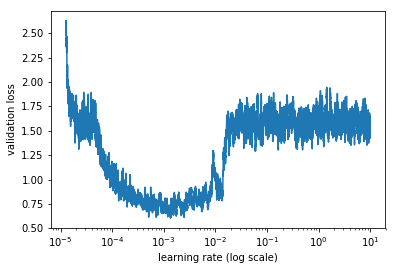

In [27]:
m.sched.plot(700)

In [28]:
lr = 2e-4

In [29]:
def mse(y_pred, targ):
    err = targ - y_pred
    return math.sqrt((err**2).mean())

In [30]:
m.fit(lr, 1, metrics=[mse])

epoch      trn_loss   val_loss   mse        
    0      0.48113    1.107824   0.906849  



[array([1.10782]), 0.9068488826528686]

In [31]:
m.save('m1')

In [32]:
fn = PATH+'Submission1b.csv'

preds = m.predict(is_test=True)
test['item_cnt_month'] = preds
test['Id'] = list(range(len(test)))
test[['Id','item_cnt_month']].to_csv(fn, index=False, mode = 'a')
FileLink(fn)

/home/ubuntu/fastai_projects1/data/predict_future_sales/Submission1b.csv

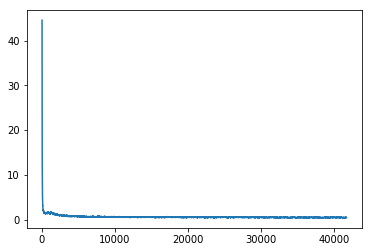

In [33]:
m.sched.plot_loss()

## Add learning rate annealing

In [34]:
m.fit(lr, 3, cycle_len = 1, cycle_mult = 2, metrics=[mse])

epoch      trn_loss   val_loss   mse        
    0      0.443312   1.249474   0.943925  
    1      0.465232   1.387181   0.992528  
 21%|██        | 8579/41702 [01:18<05:04, 108.72it/s, loss=0.442]

KeyboardInterrupt: 

## Looks like we're over-fitting. Let's change dropout.

In [45]:
m = md.get_learner(emb_szs, len(df.columns) - len(cat_vars), emb_drop=0.04, 
                  out_sz = 1, szs = [1000, 500], drops = [0.015,0.1], y_range = y_range)

In [46]:
m.fit(lr, 1, metrics=[mse])

epoch      trn_loss   val_loss   mse        
    0      0.513504   0.935313   0.817439  


[array([0.93531]), 0.817439111748875]

In [47]:
m.save('m1')

In [48]:
fn = PATH+'Submission5.csv'

preds = m.predict(is_test=True)
test['item_cnt_month'] = preds
test['Id'] = list(range(len(test)))
test[['Id','item_cnt_month']].to_csv(fn, index=False, mode = 'a')
FileLink(fn)

/home/ubuntu/fastai_projects1/data/predict_future_sales/Submission5.csv

In [49]:
m.fit(lr/5, 2, cycle_len = 1, cycle_mult = 2, metrics=[mse])

epoch      trn_loss   val_loss   mse        
    0      0.427753   0.988734   0.847692  
    1      0.459012   1.04498    0.876394  
    2      0.445775   1.054981   0.882871  


[array([1.05498]), 0.8828707360388771]

In [50]:
fn = PATH+'Submission6.csv'

preds = m.predict(is_test=True)
test['item_cnt_month'] = preds
test['Id'] = list(range(len(test)))
test[['Id','item_cnt_month']].to_csv(fn, index=False, mode = 'a')
FileLink(fn)

/home/ubuntu/fastai_projects1/data/predict_future_sales/Submission6.csv

## Fit to the whole data

In [58]:
val_idxs = np.array([0]).astype(int)  # I'll use the first month as validation (i.e. delete from training)

In [59]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df, y.astype(np.float32),
                                       cat_vars, bs = 256, test_df = df_test)

In [60]:
m = md.get_learner(emb_szs, len(df.columns) - len(cat_vars), emb_drop=0.04, 
                  out_sz = 1, szs = [1000, 500], drops = [0.015,0.1], y_range = y_range)

In [61]:
m.lr_find()

epoch      trn_loss   val_loss   
    0      1.697934   0.0       


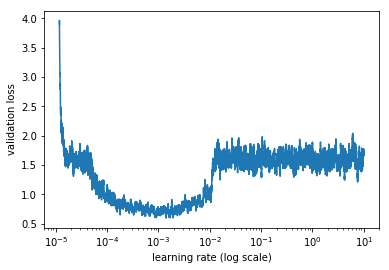

In [63]:
m.sched.plot(500)

In [64]:
lr = 1e-4

In [65]:
m.fit(lr, 1, metrics = [mse])

epoch      trn_loss   val_loss   mse        
    0      0.471511   6.6e-05    0.008133  


[array([0.00007]), 0.00813343196872336]

In [66]:
m.save('m2')

In [67]:
fn = PATH+'Submission7.csv'

preds = m.predict(is_test=True)
test['item_cnt_month'] = preds
test['Id'] = list(range(len(test)))
test[['Id','item_cnt_month']].to_csv(fn, index=False, mode = 'a')
FileLink(fn)

/home/ubuntu/fastai_projects1/data/predict_future_sales/Submission7.csv

None of my attempts scored a very good result, and couldn't even beat the public kernel using trees.